In [43]:
#imports


import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

## Two fund theorem

In [30]:
import numpy as np
import pandas as pd
import cvxpy as cp


# Load data
config_path = "/Users/vamsyvrishank/Desktop/sem2/FE630/Project/Dynamic-Beta-Hedging-Model/data/daily_returns.csv"
data = pd.read_csv(config_path)

# Convert date and index properly
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')


# Select 1-year window before Jan 2, 2025

returns_1y = data.loc["2024-01-02":"2025-01-01"]

U = ['FXE','EWJ','GLD','QQQ','SHV','DBA','USO','XBI','ILF','EPP','FEZ']
market = 'SPY'
apple_ticker = "AAPL"

# Expected returns and covariance matrix
mu = returns_1y[U].mean().values
Sigma = returns_1y[U].cov().values


print("Expected Returns : " , mu )
print("Covariance : " , Sigma)


# Compute betas

def compute_beta(asset , market):
    cov = np.cov(returns_1y[asset], returns_1y[market])[0,1]
    var_market = np.var(returns_1y[market], ddof=1)
    return cov / var_market

betas = np.array([compute_beta(asset, market) for asset in U])

print("Betas of assets:")
for asset, b in zip(U, betas):
    print(asset, ":", round(b, 6))



# Minimum Variance Optimization with Target Beta

def mvo_target_beta(beta_target):
    n = len(U)
    w = cp.Variable(n)

    objective = cp.quad_form(w, Sigma)
    constraints = [
        cp.sum(w) == 1,
        betas @ w == beta_target
    ]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    return w.value 


beta_a = 0.5
beta_b = 1.5

w_a = mvo_target_beta(beta_a)
w_b = mvo_target_beta(beta_b)

print("\nPortfolio weights for βa = 0.5:")
print(pd.Series(w_a, index=U))

print("\nPortfolio weights for βb = 1.5:")
print(pd.Series(w_b, index=U))


# Two-fund alpha

beta_c = 1
alpha = (beta_b - beta_c) / (beta_b - beta_a)  

print("\nAlpha for beta_c = 1:", alpha)

w_c = alpha * w_a + (1 - alpha) * w_b

print("\nPortfolio weights for βc = 1 (via two-fund theorem):")
print(pd.Series(w_c, index=U))

print("\nCheck β of ωmv(βc):", betas @ w_c)


Expected Returns :  [-1.36125948e-04  3.07040083e-04  9.50870127e-04  9.75402316e-04
  1.99463724e-04  1.15917179e-03  5.52314633e-04 -1.83167696e-06
 -9.91974904e-04  2.31471420e-04  1.97892195e-04]
Covariance :  [[ 1.37661150e-05  1.08385833e-05  1.26921742e-05  5.01370278e-06
   1.50860467e-07  2.71343608e-06  3.20572301e-08  1.47955557e-05
   1.49947632e-05  1.82214717e-05  2.11396257e-05]
 [ 1.08385833e-05  1.23688060e-04  3.40872744e-05  7.64183605e-05
   9.64145250e-08 -3.31534814e-06  1.56160741e-05  6.83512392e-05
   5.55736768e-05  6.65828310e-05  6.61378701e-05]
 [ 1.26921742e-05  3.40872744e-05  9.00796134e-05  2.42306278e-05
   1.86889990e-07  8.96574588e-06  3.78117398e-05  3.57791531e-05
   3.72391932e-05  4.16647495e-05  3.31894732e-05]
 [ 5.01370278e-06  7.64183605e-05  2.42306278e-05  1.28294879e-04
   1.83350298e-08  6.10501515e-06  8.99704013e-06  8.93047492e-05
   5.37554144e-05  5.89612676e-05  6.27427802e-05]
 [ 1.50860467e-07  9.64145250e-08  1.86889990e-07  1.8

## Hedging a long position in Apple 

###  Beta Hedged Portfolio

In [26]:
# we already computed betas of securities 

print("Betas of assets:")
for asset, b in zip(U, betas):
    print(asset, ":", round(b, 6))


apple_beta = compute_beta(apple_ticker , market)

weights_basket = mvo_target_beta(apple_beta)

print("\nMinimum Variance Portfolio with beta_A:")
print(pd.Series(weights_basket, index=U))

mu_basket = mu @ weights_basket
mu_apple = returns_1y[apple_ticker].mean()
mu_hedged = mu_apple - mu_basket


print("Apple beta : " , apple_beta)

print("\nExpected return of hedge basket:", mu_basket)
print("Expected return of basket AAPL strategy:", mu_apple)




Minimum Variance Portfolio with beta_A:
FXE   -0.129644
EWJ    0.006749
GLD    0.003732
QQQ    0.578823
SHV    0.351922
DBA   -0.012699
USO   -0.012720
XBI    0.046051
ILF    0.050272
EPP    0.097910
FEZ    0.019604
dtype: float64

Expected return of hedge basket: 0.0006128943973507471
Expected return of hedged AAPL strategy: 0.0012120209613770507


In [28]:
apple_beta = compute_beta(apple_ticker, market)

weights_hedged = mvo_target_beta(apple_beta)   

print("\nMinimum Variance Portfolio with beta_A:")
print(pd.Series(weights_hedged, index=U))

# Expected returns
mu_basket = mu @ weights_hedged
mu_apple = returns_1y[apple_ticker].mean()

# Hedged strategy expected return
mu_hedged = mu_apple - mu_basket

print("\nExpected return of hedge basket:", mu_basket)
print("Expected return of hedged AAPL strategy:", mu_hedged)
print("Expected return of  AAPL :", mu_apple)



Minimum Variance Portfolio with beta_A:
FXE   -0.129644
EWJ    0.006749
GLD    0.003732
QQQ    0.578823
SHV    0.351922
DBA   -0.012699
USO   -0.012720
XBI    0.046051
ILF    0.050272
EPP    0.097910
FEZ    0.019604
dtype: float64

Expected return of hedge basket: 0.0006128943973507471
Expected return of hedged AAPL strategy: 0.0005991265640263036
Expected return of  AAPL : 0.0012120209613770507


Beta hedge removes systematic risk, not alpha.

### Beta Neutral Portfolio


In [34]:
universe = ['AAPL', 'FXE','EWJ','GLD','QQQ','SHV','DBA','USO','XBI','ILF','EPP','FEZ']
# Betas (AAPL included)
betas_universe = np.array([compute_beta(asset, market) for asset in universe])

# Covariance 
Sigma_universe = returns_1y[universe].cov().values

# Expected returns
mu_universe = returns_1y[universe].mean().values


def mvo_target_beta_general(beta_target, assets, Sigma_matrix, beta_vec):
    n = len(assets)
    w = cp.Variable(n)

    objective = cp.quad_form(w, Sigma_matrix)
    constraints = [
        cp.sum(w) == 1,
        beta_vec @ w == beta_target
    ]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    return np.array(w.value)


w_beta_neutral = mvo_target_beta_general(0, universe, Sigma_universe, betas_universe)

print("\nBeta Neutral Minimum Variance Portfolio weights (Universe V):")
print(pd.Series(w_beta_neutral, index=universe))


#hedged straetgy from previous part 

w_hedged = np.zeros(len(universe))
w_hedged[universe.index("AAPL")] = 1      # long AAPL
w_hedged[1:] = -weights_hedged     # short hedge basket , APPL is first element here


#metrics for both portfolios

#expected returns 
mu_beta_neutral =  mu_universe @ w_beta_neutral
mu_hedged_strategy = mu_universe @ w_hedged

#variance and standard deviation

var_beta_neutral = w_beta_neutral.T @ Sigma_universe @ w_beta_neutral
var_hedged_strategy = w_hedged.T @ Sigma_universe @ w_hedged

#betas of both strategies
beta_beta_neutral = betas_universe @ w_beta_neutral
beta_beta_hedged  = betas_universe @ w_hedged


summary = pd.DataFrame({
    "Beta-Neutral MV Portfolio": [mu_beta_neutral, var_beta_neutral, beta_beta_neutral],
    "AAPL Hedged Strategy": [mu_hedged_strategy, var_hedged_strategy, beta_beta_hedged]
}, index=["Expected Return", "Variance", "Beta"])

print("\nComparison of Beta-Neutral MV vs Hedged Strategy:")
print(summary)




Beta Neutral Minimum Variance Portfolio weights (Universe V):
AAPL   -0.000479
FXE    -0.006833
EWJ     0.000394
GLD    -0.001558
QQQ     0.000696
SHV     1.005960
DBA     0.001232
USO     0.001649
XBI    -0.000234
ILF     0.000948
EPP    -0.001495
FEZ    -0.000279
dtype: float64

Comparison of Beta-Neutral MV vs Hedged Strategy:
                 Beta-Neutral MV Portfolio  AAPL Hedged Strategy
Expected Return               2.013181e-04          5.991266e-04
Variance                      2.470001e-08          1.371214e-04
Beta                         -3.034497e-15          1.228040e-15


### Backtesting from Jan 2025 to March 2025


In [36]:
returns_test = data.loc["2025-01-03":"2025-03-30"]

returns_universe = returns_test[universe]   # universe: ['AAPL', FXE, ..., FEZ]
returns_U = returns_test[U]   # just the ETF's without apple


#hedged strategy
R_AAPL = returns_test["AAPL"].values
R_hedgebasket = returns_U.values @ weights_hedged

R_hedged_strategy = R_AAPL - R_hedgebasket
R_hedged_strategy = pd.Series(R_hedged_strategy, index=returns_test.index)

#beta neutral mvp strategy 
R_beta_neutral = returns_universe.values @ w_beta_neutral
R_beta_neutral = pd.Series(R_beta_neutral, index=returns_test.index)

print("\nSample of realized daily returns:")
print(pd.DataFrame({
    "Hedged Strategy": R_hedged_strategy.head(10),
    "Beta-Neutral MV": R_beta_neutral.head(10)
}))



Sample of realized daily returns:
            Hedged Strategy  Beta-Neutral MV
Date                                        
2025-01-03        -0.011732         0.000256
2025-01-06        -0.000598         0.000123
2025-01-07        -0.002079         0.000231
2025-01-08         0.001858        -0.000026
2025-01-10        -0.011124         0.000409
2025-01-13        -0.008716         0.000266
2025-01-14        -0.002931         0.000016
2025-01-15         0.002786         0.000240
2025-01-16        -0.036964         0.000031
2025-01-17        -0.002887         0.000487


### Risk Statistics 

In [38]:
# compute stats

def portfolio_stats(series):
    mean_ret = series.mean()
    vol = series.std()
    var95 = np.percentile(series, 5)  # 95% historical VaR
    sk = skew(series)
    kt = kurtosis(series)
    return mean_ret, vol, var95, sk, kt


stats_hedged = portfolio_stats(R_hedged_strategy)
stats_beta_neutral = portfolio_stats(R_beta_neutral)

R_SPY_test = returns_test["SPY"]


def realized_beta(series, market):
    cov = np.cov(series, market)[0,1]
    var = np.var(market)
    return cov / var


beta_realized_hedged = realized_beta(R_hedged_strategy, R_SPY_test)
beta_realized_beta0  = realized_beta(R_beta_neutral, R_SPY_test)


summary3 = pd.DataFrame({
    "Hedged Strategy": [
        stats_hedged[0], stats_hedged[1], stats_hedged[2],
        stats_hedged[3], stats_hedged[4], beta_realized_hedged
    ],
    "Beta-Neutral MV Portfolio": [
        stats_beta_neutral[0], stats_beta_neutral[1], stats_beta_neutral[2],
        stats_beta_neutral[3], stats_beta_neutral[4], beta_realized_beta0
    ]
}, index=["Mean Return", "Volatility", "95% VaR",
          "Skewness", "Kurtosis", "Realized Beta"])

print("\nRealized risk and return comparison (Jan–Mar 2025):")
print(summary3)


Realized risk and return comparison (Jan–Mar 2025):
               Hedged Strategy  Beta-Neutral MV Portfolio
Mean Return          -0.000322                   0.000167
Volatility            0.016667                   0.000146
95% VaR              -0.030485                  -0.000019
Skewness              0.008052                   0.409349
Kurtosis              1.296467                  -0.594138
Realized Beta        -0.254852                  -0.001401


### Chasing Performance 

In [ ]:
beta_A = compute_beta(apple_ticker , market)

def mvo_target_beta_return_chasing(beta_target, lambda_param):
    """
    Solve: min_w  w^T Σ w  - λ μ^T w
    subject to sum(w)=1 and beta(w)=beta_target
    """

    n = len(U)
    w = cp.Variable(n)

    # Objective: variance - λ * expected return
    objective = cp.quad_form(w, Sigma) - lambda_param * (mu @ w)

    constraints = [
        cp.sum(w) == 1,
        betas @ w == beta_target
    ]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    return np.array(w.value)

lambda_param = 6
w_hedge_return_chasing = mvo_target_beta_return_chasing(beta_A, lambda_param)

#computing the returns of new hedged strategy
mu_basket_chasing = mu @ w_hedge_return_chasing
mu_apple = returns_1y[apple_ticker].mean()
mu_hedged_chasing = mu_apple - mu_basket_chasing
var_basket_chasing = w_hedge_return_chasing.T @ Sigma @ w_hedge_return_chasing


print("\nReturn-Chasing Hedge Portfolio Weights (λ = {}):".format(lambda_param))
print(pd.Series(w_hedge_return_chasing, index=U))
print("\nExpected return of hedge basket (return-chasing):", mu_basket_chasing)
print("Expected return of hedged AAPL strategy (return-chasing):", mu_hedged_chasing)
print("Variance of hedge basket (return-chasing):", var_basket_chasing)



### Dynamic Hedging

In [42]:

window = 60               # 60-day rolling window
rebalance_every = 5       # weekly rebalancing
test_returns = data.loc["2025-01-03":"2025-03-30"]


dynamic_pnl = []
dynamic_dates = []

all_assets = U            # only using ETF basket for hedging
R_full = data[all_assets]
R_AAPL_full = data["AAPL"]
R_SPY_full = data["SPY"]

dates = test_returns.index


for i in range( 0 , len(dates) , rebalance_every):

    t = dates[i]
    start = R_full.index.get_loc(t) - window
    end = R_full.index.get_loc(t)

    if start < 0 : continue

    R_window = R_full.iloc[start:end]
    AAPL_window = R_AAPL_full.iloc[start:end]
    SPY_window = R_SPY_full.iloc[start:end]

    # --- Compute betas & covariance for window ---
    Sigma_t = R_window.cov().values
    mu_t = R_window.mean().values

    betas_t = np.array([
        np.cov(R_window[asset], SPY_window)[0,1] /
        np.var(SPY_window, ddof=1)
        for asset in all_assets
    ])

    beta_AAPL_t = np.cov(AAPL_window, SPY_window)[0,1] / np.var(SPY_window, ddof=1)

    # --- Solve hedge weights at this time ---
    n = len(all_assets)
    w = cp.Variable(n)

    objective = cp.quad_form(w, Sigma_t)
    constraints = [
        cp.sum(w) == 1,
        betas_t @ w == beta_AAPL_t
    ]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    w_t = np.array(w.value)


        # --- Apply hedge for next week ---
    next_dates = dates[i:i+rebalance_every]

    for day in next_dates:
        if day not in R_full.index:
            continue
        
        R_AAPL_today = R_AAPL_full.loc[day]
        R_basket_today = R_full.loc[day].values @ w_t

        pnl_today = R_AAPL_today - R_basket_today

        dynamic_pnl.append(pnl_today)
        dynamic_dates.append(day)


# Convert to Series
dynamic_pnl = pd.Series(dynamic_pnl, index=dynamic_dates)

print("\nDynamic Hedged Strategy PnL:")
print(dynamic_pnl.head(20))





Dynamic Hedged Strategy PnL:
2025-01-03   -0.008759
2025-01-06    0.002139
2025-01-07   -0.003779
2025-01-08    0.001911
2025-01-10   -0.011957
2025-01-13   -0.009444
2025-01-14   -0.003376
2025-01-15    0.007869
2025-01-16   -0.035877
2025-01-17    0.000007
2025-01-21   -0.037289
2025-01-22   -0.001162
2025-01-23   -0.003259
2025-01-24   -0.001606
2025-01-27    0.044715
2025-01-28    0.031175
2025-01-29    0.005849
2025-01-30   -0.010665
2025-01-31   -0.005532
2025-02-03   -0.032370
dtype: float64


#### Interpretation 

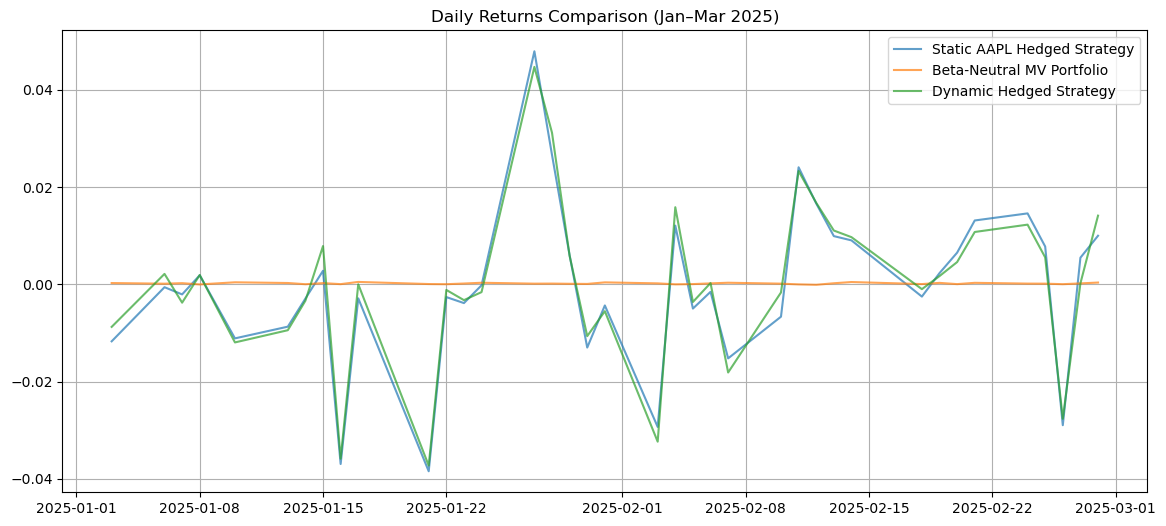

In [44]:


plt.figure(figsize=(14,6))
plt.plot(R_hedged_strategy, label="Static AAPL Hedged Strategy", alpha=0.7)
plt.plot(R_beta_neutral, label="Beta-Neutral MV Portfolio", alpha=0.7)
plt.plot(dynamic_pnl, label="Dynamic Hedged Strategy", alpha=0.7)
plt.title("Daily Returns Comparison (Jan–Mar 2025)")
plt.legend()
plt.grid(True)
plt.show()


Observation

* Static hedge (blue) and Dynamic hedge (green) have large day-to-day swings: ±3–5% moves.

* Beta-Neutral MV portfolio (orange) is almost a flat line (tiny returns ~0.0%).

Interpretation

* The static hedge is extremely noisy → beta drift + mismatched weights.

* Dynamic hedge moves very similarly to static hedge → because AAPL is extremely volatile.

* MV portfolio is very stable → this is expected because it minimizes variance under β=0 constraint.

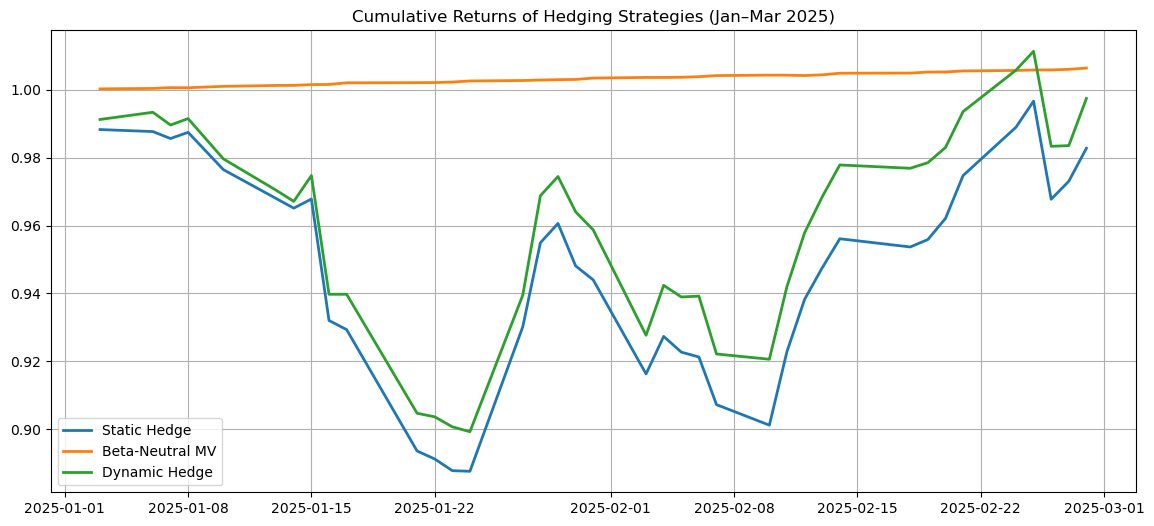

In [45]:
cum_static = (1 + R_hedged_strategy).cumprod()
cum_beta0 = (1 + R_beta_neutral).cumprod()
cum_dynamic = (1 + dynamic_pnl).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cum_static, label="Static Hedge", linewidth=2)
plt.plot(cum_beta0, label="Beta-Neutral MV", linewidth=2)
plt.plot(cum_dynamic, label="Dynamic Hedge", linewidth=2)
plt.title("Cumulative Returns of Hedging Strategies (Jan–Mar 2025)")
plt.legend()
plt.grid(True)
plt.show()


Observation

* Static hedge (blue) trends downward until mid-Feb (bad), then recovers somewhat.

* Dynamic hedge (green) performs better than static hedge:

* smaller drawdowns

* quicker recovery

* ends near 0% return

* Beta-Neutral MV (orange) is nearly flat and slightly positive.

Interpretation

* Dynamic hedge outperforms static hedge in cumulative return during the volatile January period.

* Static hedge suffers from beta misalignment and portfolio weights that don’t adapt.

* Dynamic hedge adjusts weekly → avoids the large early losses that static hedge suffered.

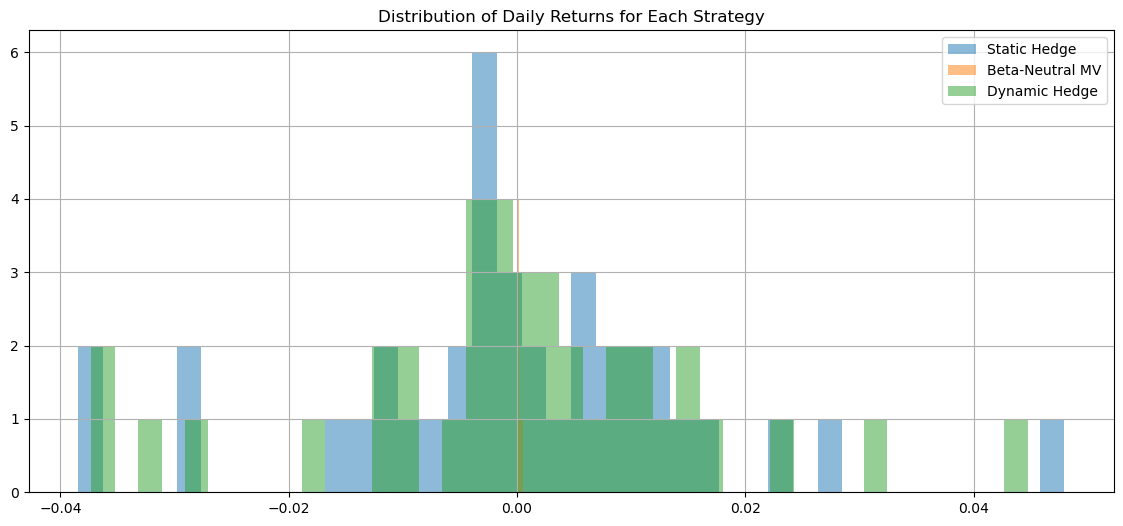

In [46]:
plt.figure(figsize=(14,6))
plt.hist(R_hedged_strategy, bins=40, alpha=0.5, label="Static Hedge")
plt.hist(R_beta_neutral, bins=40, alpha=0.5, label="Beta-Neutral MV")
plt.hist(dynamic_pnl, bins=40, alpha=0.5, label="Dynamic Hedge")
plt.title("Distribution of Daily Returns for Each Strategy")
plt.legend()
plt.grid(True)
plt.show()


Obervation 

 Static hedge and dynamic hedge have:

- Wide return distribution

- Fat tails

- Many ±2–4% returns

Beta-Neutral MV has:

- Very tight distribution

- Near-zero variance

- Almost no tails


Interpretation 


- Static and dynamic hedges still inherit AAPL’s idiosyncratic swings.

- Dynamic hedge has slightly narrower distribution compared to static hedge.

- MV β=0 portfolio is extremely well behaved.

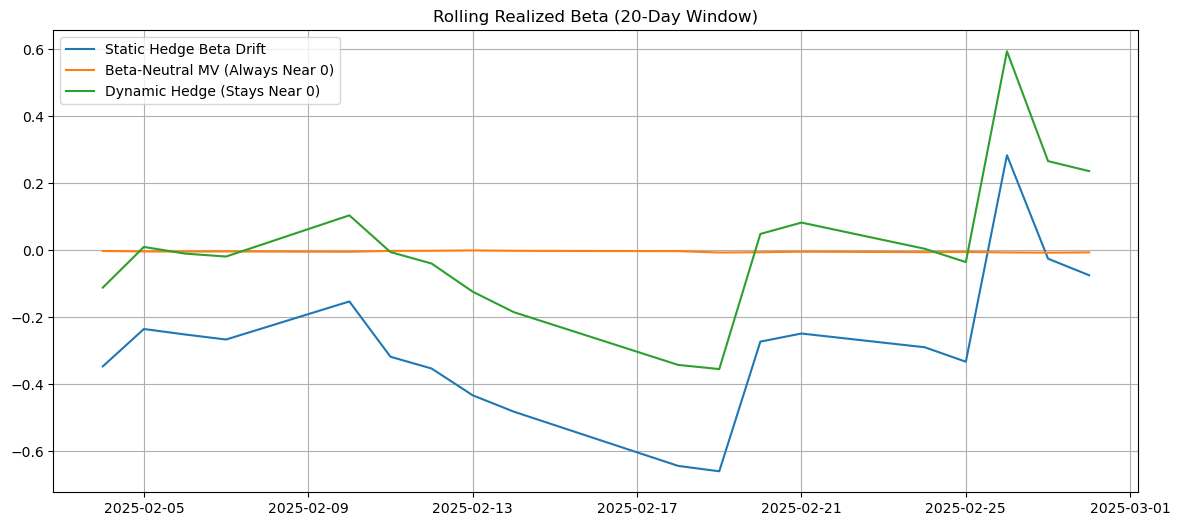

In [47]:
# Rolling beta calculation function
def rolling_beta(series, market, window=20):
    betas = []
    for i in range(window, len(series)):
        cov = np.cov(series.iloc[i-window:i], market.iloc[i-window:i])[0,1]
        var = np.var(market.iloc[i-window:i])
        betas.append(cov / var)
    index = series.index[window:]
    return pd.Series(betas, index=index)

rolling_beta_static = rolling_beta(R_hedged_strategy, returns_test["SPY"])
rolling_beta_beta0 = rolling_beta(R_beta_neutral, returns_test["SPY"])
rolling_beta_dynamic = rolling_beta(dynamic_pnl, returns_test["SPY"])

plt.figure(figsize=(14,6))
plt.plot(rolling_beta_static, label="Static Hedge Beta Drift")
plt.plot(rolling_beta_beta0, label="Beta-Neutral MV (Always Near 0)")
plt.plot(rolling_beta_dynamic, label="Dynamic Hedge (Stays Near 0)")
plt.title("Rolling Realized Beta (20-Day Window)")
plt.legend()
plt.grid(True)
plt.show()


Observation

Static hedge beta drift:

- Starts around −0.3

- Falls to −0.6

- Then jumps to +0.25
→ MASSIVE instability

Dynamic hedge beta:

- Stays near 0 most of the time

- Occasional ±0.2 jumps, but much more stable

- Ends near +0.25 for a short period (AAPL spike)

- Beta-neutral MV portfolio:

- Perfectly flat at 0

- As expected

Interpretation

- Static hedge fails as a beta hedge.

- Dynamic hedge keeps beta near 0, which is exactly what the theory predicted.

- Dynamic hedge is dramatically more stable than static hedge.